# HDBSCAN Clustering Hyperparameter Tuning

## Goal

The goal of this notebooks is to tune the hyperparameters of the HDBSCAN clustering algorithm to minimize the number of points that are not assigned to any cluster.
The code here also allows for optimizing the number of clusters to be the exact number of clusters specified in the data generation process.

## Results
### Different Datasets
For the simple 3 normal distributions which are somewhat separable the number of unassigned points was reduced by half to $\approx 6$ percent, compared to the hyperparameters used by Laura.
For 3 simple normal distributions, which are not separable, the method failed to find the intended structure. For the minimal number of unassigned points, the number of clusters is very high.

For 7 and small variance it seems to not find the right number of clusters, even if the hyperparameters are optimized for it, but the number of unassigned can be significantly reduced (sometimes, seems to depend on the random instance of the dataset).

The optimization for the 32 dimensions only works sometimes. It seems to be very unstable.

### General Hyperparameter Trends
The $\alpha$ value is set as low as possible. The min_cluster_size and min_samples are large when the number of underlying clusters is low. This makes sense, because this my force the algorithm to break up the dataset into few clusters if the number of datapoints is a small multiple of these parameters. This also explains the result for these datasets.
The cluster selection method always results in "eom", it is not clear to me why. The epsilon parameter is sometimes large.

- Paper link explaining the $\alpha$ parameter https://papers.nips.cc/paper_files/paper/2010/file/b534ba68236ba543ae44b22bd110a1d6-Paper.pdf


## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import HDBSCAN

from corc.generation import GenerationModel

%matplotlib inline

In [9]:
parameters = [
    {
        "name": "min_cluster_size",
        "type": "range",
        "bounds": [2, 300],
    },
    {
        "name": "min_samples",
        "type": "range",
        "bounds": [2, 300],
    },
    {
        "name": "alpha",
        "type": "range",
        "bounds": [1e-3, 1e2],
    },
    {
        "name": "cluster_selection_epsilon",
        "type": "range",
        "bounds": [0.0, 10.0],
    },
    {
        "name": "cluster_selection_method",
        "type": "choice",
        "values": ["eom", "leaf"],
    },
]

## 3 Normal Distributions in 2D

[INFO 01-11 14:04:27] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:04:27] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:04:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:04:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter cluster_selection_epsilon. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float',

[INFO 01-11 14:04:27] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-11 14:04:27] ax.modelbridge.transforms.standardize_y: Outcome objective is constant, within tolerance.
/home/anton/anaconda3/envs/cvc/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.], dtype=torch.float64), std = tensor([0.], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
[INFO 01-11 14:04:29] ax.service.managed_loop: Running optimization trial 3...
/home/anton/anaconda3/envs/cvc/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/anton/anaconda3/envs/cvc/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[INFO 01-11 14:04:33] a

{'min_cluster_size': 108, 'min_samples': 102, 'alpha': 0.001, 'cluster_selection_epsilon': 9.195512457840373, 'cluster_selection_method': 'eom'}


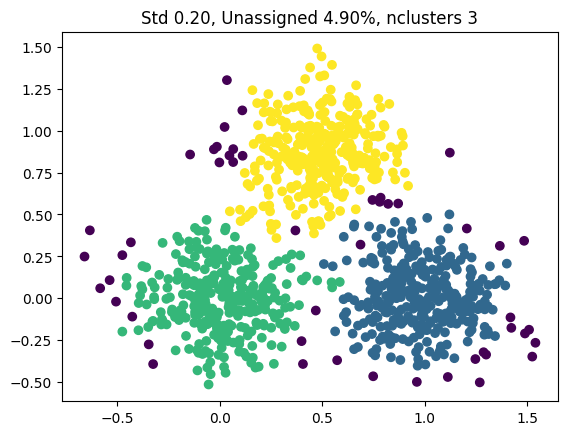

In [10]:
from ax import optimize

params = {
    "center_structure": "equidistant_triangle",
    "n_centers": 3,
    "distance": 1,
    "n_samples": 1000,
    "dim": 2,
    "save_file": False,
    "outdir": ".",
}

gen = GenerationModel(**params)
gen.generate()


def unassigned_points(args, gen, plot=False, std=0.2, unique=None):
    data = gen.sample_embedding(std=std)
    clustering = HDBSCAN(**args)
    clustering.fit(data)
    labels_clean = clustering.labels_.copy()[clustering.labels_ != -1]

    if plot:
        plt.scatter(data[:, 0], data[:, 1], c=clustering.labels_)
        plt.title(
            f"Std {std:.2f}, Unassigned {(clustering.labels_ == -1).mean()*100:.2f}%,"
            f" nclusters {len(np.unique(labels_clean))}"
        )
        plt.show()

    if unique is not None:
        if len(np.unique(labels_clean)) != unique:
            return abs(len(np.unique(labels_clean)) - unique)

    result = (clustering.labels_ == -1).mean()
    return result


std = 0.2
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=lambda p: (unassigned_points(p, gen=gen, std=std), np.nan),
    minimize=True,
    total_trials=10,
    arms_per_trial=2,
)
print(best_parameters)
unassigned_points(best_parameters, gen=gen, plot=True, std=std)
None

## ## 3 Normal Distributions in 2D - Increased Variance

[INFO 01-11 14:05:01] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:05:01] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:05:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:05:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter cluster_selection_epsilon. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float',

{'min_cluster_size': 2, 'min_samples': 2, 'alpha': 0.001, 'cluster_selection_epsilon': 7.389927764573187, 'cluster_selection_method': 'eom'}


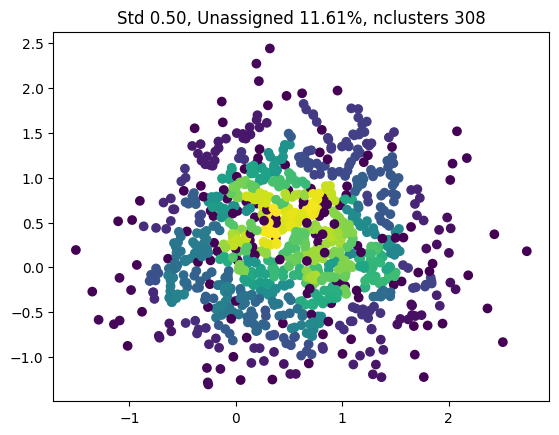

In [11]:
std = 0.5
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=lambda p: (unassigned_points(p, gen=gen, std=std), np.nan),
    minimize=True,
    total_trials=10,
    arms_per_trial=2,
)
print(best_parameters)
unassigned_points(best_parameters, gen=gen, plot=True, std=std)
None

## 7 Normal Distributions in 2D

[INFO 01-11 14:05:42] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:05:42] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:05:42] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:05:42] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter cluster_selection_epsilon. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float',

{'min_cluster_size': 300, 'min_samples': 300, 'alpha': 0.001, 'cluster_selection_epsilon': 0.0, 'cluster_selection_method': 'eom'}


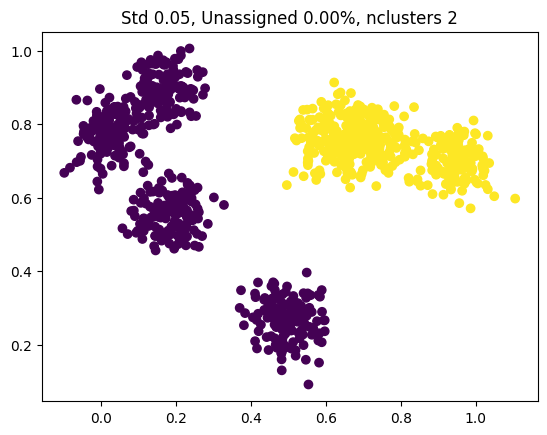

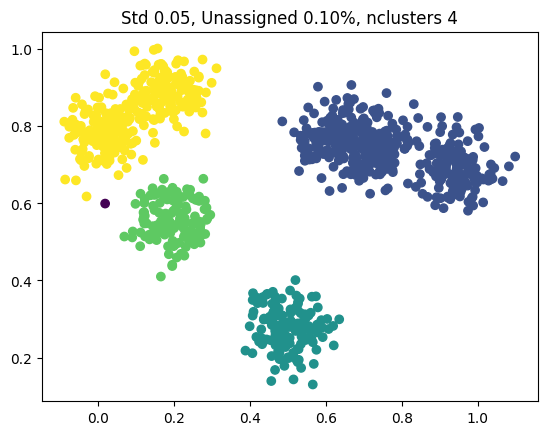

In [12]:
params = {
    "center_structure": "uniform",
    "n_centers": 7,
    "distance": 1,
    "n_samples": 1000,
    "dim": 2,
    "save_file": False,
    "outdir": ".",
}

gen = GenerationModel(**params)
gen.generate()

std = 0.05
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=lambda p: (unassigned_points(p, gen=gen, std=std), np.nan),
    minimize=True,
    total_trials=10,
    arms_per_trial=2,
)
print(best_parameters)
unassigned_points(best_parameters, gen=gen, plot=True, std=std)
unassigned_points({"min_cluster_size": 4}, gen=gen, plot=True, std=std)
None

## 7 Normals with Higher Variance

[INFO 01-11 14:07:07] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:07:07] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:07:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:07:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter cluster_selection_epsilon. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float',

{'min_cluster_size': 2, 'min_samples': 257, 'alpha': 0.001, 'cluster_selection_epsilon': 9.173807347347914, 'cluster_selection_method': 'leaf'}


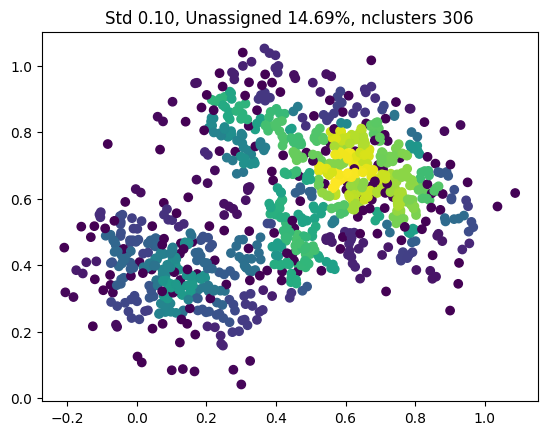

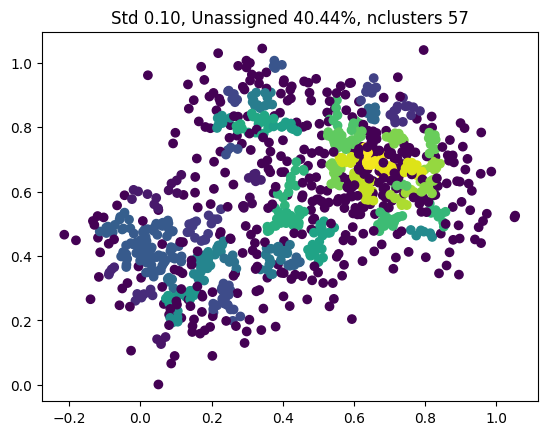

In [13]:
params = {
    "center_structure": "uniform",
    "n_centers": 7,
    "distance": 1,
    "n_samples": 1000,
    "dim": 2,
    "save_file": False,
    "outdir": ".",
}

gen = GenerationModel(**params)
gen.generate()

std = 0.1
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=lambda p: (unassigned_points(p, gen=gen, std=std), np.nan),
    minimize=True,
    total_trials=10,
    arms_per_trial=2,
)
print(best_parameters)
unassigned_points(best_parameters, gen=gen, plot=True, std=std)
unassigned_points({"min_cluster_size": 4}, gen=gen, plot=True, std=std)
None

## 3 Normal Distributions in 32 Dimensions

[INFO 01-11 14:12:59] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:12:59] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:12:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:12:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter cluster_selection_epsilon. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float',

{'min_cluster_size': 2, 'min_samples': 2, 'alpha': 0.001, 'cluster_selection_epsilon': 1.638086486676297, 'cluster_selection_method': 'eom'}


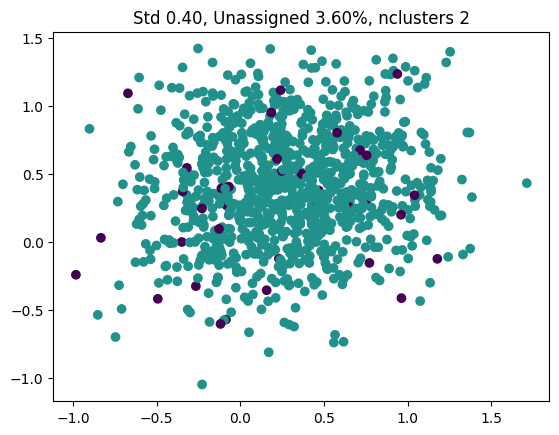

0.036036036036036036

In [18]:
from sklearn.manifold import trustworthiness, TSNE

params = {
    "center_structure": "uniform",
    "n_centers": 3,
    "distance": 1,
    "n_samples": 1000,
    "dim": 32,
    "save_file": False,
    "outdir": ".",
}

gen = GenerationModel(**params)
gen.generate()

std = 0.4
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=lambda p: (unassigned_points(p, gen=gen, std=std), np.nan),
    minimize=True,
    total_trials=10,
    arms_per_trial=2,
)
print(best_parameters)
unassigned_points(best_parameters, gen=gen, plot=True, std=std)

fraction of unassigned points 11.71%


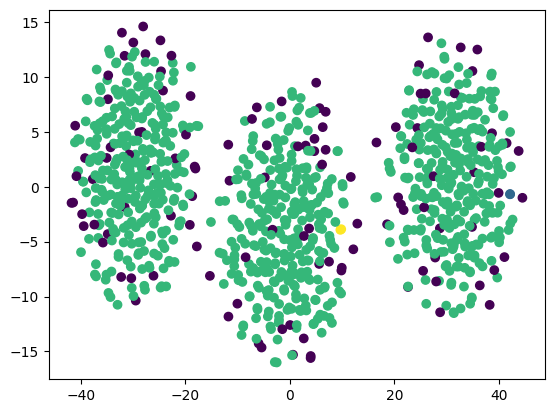

In [19]:
data = gen.sample_embedding(std=std)
tsne = TSNE(n_components=2).fit_transform(data)

# cluster = HDBSCAN(min_cluster_size=10, min_samples=3)
cluster = HDBSCAN(**best_parameters)
cluster.fit(data)

unassigned = (cluster.labels_ == -1).mean()
print(f"fraction of unassigned points {unassigned * 100:.2f}%")

plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster.labels_)

[INFO 01-11 14:13:48] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:13:48] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_samples. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:13:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-11 14:13:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter cluster_selection_epsilon. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float',

{'min_cluster_size': 84, 'min_samples': 28, 'alpha': 0.001, 'cluster_selection_epsilon': 7.607341528133288, 'cluster_selection_method': 'eom'}


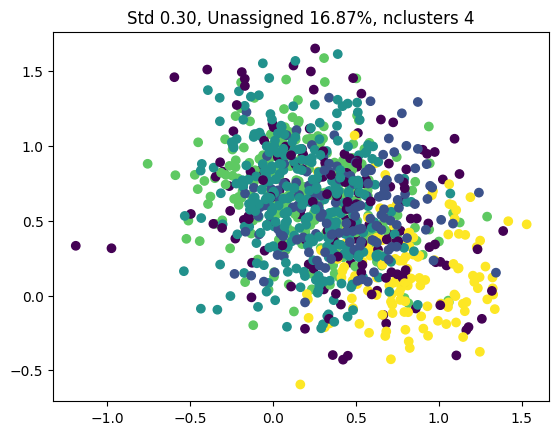

0.1686746987951807

In [20]:
from sklearn.manifold import trustworthiness, TSNE

params = {
    "center_structure": "uniform",
    "n_centers": 6,
    "distance": 1,
    "n_samples": 1000,
    "dim": 32,
    "save_file": False,
    "outdir": ".",
}

gen = GenerationModel(**params)
gen.generate()

std = 0.3
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=lambda p: (unassigned_points(p, gen=gen, std=std), np.nan),
    minimize=True,
    total_trials=20,
    arms_per_trial=2,
)
print(best_parameters)
unassigned_points(best_parameters, gen=gen, plot=True, std=std)

fraction of unassigned points 17.57%


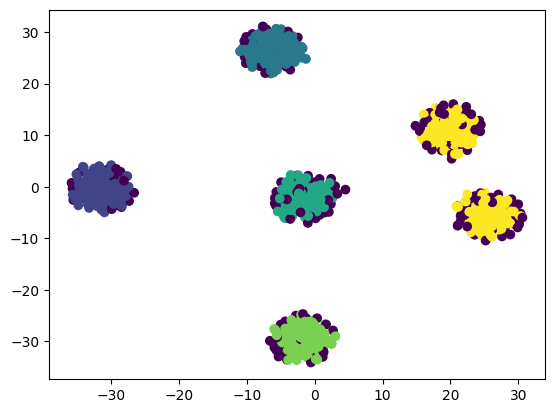

In [21]:
data = gen.sample_embedding(std=std)
tsne = TSNE(n_components=2).fit_transform(data)

# cluster = HDBSCAN(min_cluster_size=10, min_samples=3)
cluster = HDBSCAN(**best_parameters)
cluster.fit(data)

unassigned = (cluster.labels_ == -1).mean()
print(f"fraction of unassigned points {unassigned * 100:.2f}%")

plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster.labels_)